# Análisis de CelebA

## Imports iniciales y carga

Lo primero, como es usual, es cargar los ficheros y examinar su contenido.

Este conjunto de datos viene con tres ficheros de texto, con campos separados por espacios:
- `list_attr_celeba.txt`: tiene las etiquetas binarias de cada imagen.
- `identity_CelebA.txt`: indica a qué celebridad corresponde cada imagen, aunque esta información está anonimizada
- `list_eval_partition.txt`: indica las particiones del conjunto de datos (entrenamiento, validación, test)

In [2]:
import pandas as pd
import os

Antes de nada, para poder estratificar este conjunto de datos de manera justa, también es conveniente cargar AVA para ver el nivel de desbalanceo que presenta, además de definir variables para ayudar a dividir el conjunto de datos de manera similar a AVA y a Photozilla

In [3]:
ava_info_folder = os.environ['AVA_info_folder']
ava_df = pd.read_csv(f'{ava_info_folder}/info.csv', index_col=0)

positive_frac = len(ava_df[ava_df['VotesMean'] > 5.0]) / len(ava_df)
negative_frac = 1 - positive_frac

target_images = 10000
test_split = 0.08
val_split = 0.2

test_images = test_split * target_images
val_images = (10000 - test_images) * val_split
train_images = 10000 - test_images - val_images

In [4]:
df_attributes = pd.read_csv('/srv/celeba/list_attr_celeba.txt', sep='\s+')
df_attributes.head()

,file,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
print(f'Valores perdidos: {df_attributes.isnull().sum().sum()}')
print(f'Valores cero: {(df_attributes == 0).sum().sum()}')

Valores perdidos: 0
Valores cero: 0


In [6]:
for column in df_attributes.columns:
    print(f'Valores distintos en {column}:\n {df_attributes[column].value_counts()}')

Valores distintos en file:
 000001.jpg    1
135060.jpg    1
135062.jpg    1
135063.jpg    1
135064.jpg    1
             ..
067536.jpg    1
067537.jpg    1
067538.jpg    1
067539.jpg    1
202599.jpg    1
Name: file, Length: 202599, dtype: int64
Valores distintos en 5_o_Clock_Shadow:
 -1    180083
 1     22516
Name: 5_o_Clock_Shadow, dtype: int64
Valores distintos en Arched_Eyebrows:
 -1    148509
 1     54090
Name: Arched_Eyebrows, dtype: int64
Valores distintos en Attractive:
  1    103833
-1     98766
Name: Attractive, dtype: int64
Valores distintos en Bags_Under_Eyes:
 -1    161153
 1     41446
Name: Bags_Under_Eyes, dtype: int64
Valores distintos en Bald:
 -1    198052
 1      4547
Name: Bald, dtype: int64
Valores distintos en Bangs:
 -1    171890
 1     30709
Name: Bangs, dtype: int64
Valores distintos en Big_Lips:
 -1    153814
 1     48785
Name: Big_Lips, dtype: int64
Valores distintos en Big_Nose:
 -1    155083
 1     47516
Name: Big_Nose, dtype: int64
Valores distintos en Blac

No parece haber valores perdidos, tanto codificados como `NaN` como 0, ni como otro número que no sea -1 o 1

In [7]:
df_celebrities = pd.read_csv('/srv/celeba/identity_CelebA.txt', sep='\s+')
df_celebrities.head()

,file,celebrity
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


In [8]:
print(f'Valores perdidos: {df_celebrities.isnull().sum().sum()}')
print(f'Valores cero: {(df_celebrities == 0).sum().sum()}')

Valores perdidos: 0
Valores cero: 0


En este conjunto de datos tampoco parece haber valores perdidos.

In [9]:
df_partitions = pd.read_csv('/srv/celeba/list_eval_partition.txt', sep='\s+')
df_partitions

,file,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,2
202595,202596.jpg,2
202596,202597.jpg,2
202597,202598.jpg,2


In [10]:
df_partitions['partition'].value_counts()

0    162770
2     19962
1     19867
Name: partition, dtype: int64

## Preprocesamiento de los datos

Habiendo confirmado ya que no hay valores perdidos ni anómalos, el siguiente paso que se puede realizar es centralizar toda esta información en un solo `DataFrame`. Además, de cara a entrenar los modelos, sería mejor tener las etiquetas negativas como 0; y las positivas, como 1.

Además, según el artículo de CelebA, la partición 0 se usa para entrenar los modelos de *deep learning*. Para mantener una metodología parecida a AVA y Photozilla, pues en estos casos las particiones no generan categorías disjuntas (como es el caso de los famosos aquí), se utilizará solo esta partición.

In [11]:
df = df_attributes.join(df_celebrities, lsuffix='', rsuffix='_other').drop('file_other', axis=1)
df = df.join(df_partitions, lsuffix='', rsuffix='_other').drop('file_other', axis=1)
df = df[df['partition'] == 0]
df.head()

,file,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,celebrity,partition
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,-1,1,-1,1,-1,-1,1,2880,0
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,1,2937,0
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,1,8692,0
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,1,-1,1,-1,1,1,-1,1,5805,0
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,1,-1,-1,1,9295,0


In [12]:
df.loc[:, df.columns != 'file'] = df.loc[:, df.columns != 'file'].applymap(lambda x: 0 if x == -1 else x)
df.head()

,file,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,celebrity,partition
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,1,0,1,0,1,0,0,1,2880,0
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,2937,0
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,8692,0
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,1,0,1,0,1,1,0,1,5805,0
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,9295,0


## Análisis de los datos

Una vez hecho todo esto, ya se puede pasar a analizar el conjunto de datos. Por ejemplo, se puede ver cuán desbalanceada está cada etiqueta, y ver qué desbalanceos son más similares a los de AVA:

In [13]:
label_balances = df.iloc[:,1:-2].apply(lambda col: sum(col) / len(col))
label_balances = label_balances.apply(lambda x: abs(positive_frac - (x if x > 0.5 else 1 - x))).sort_values()
label_balances

Oval_Face              0.009092
Pointy_Nose            0.016802
Arched_Eyebrows        0.026435
Wavy_Hair              0.027039
Big_Lips               0.051409
Black_Hair             0.053295
Big_Nose               0.056767
Young                  0.071259
Straight_Hair          0.083762
Bags_Under_Eyes        0.087860
Brown_Hair             0.088400
Heavy_Makeup           0.091995
Wearing_Earrings       0.105787
No_Beard               0.126497
Male                   0.127051
Bangs                  0.140664
Blond_Hair             0.143232
Bushy_Eyebrows         0.148645
High_Cheekbones        0.160128
Wearing_Necklace       0.170897
Narrow_Eyes            0.176396
Wearing_Lipstick       0.177281
5_o_Clock_Shadow       0.180647
Smiling                0.187375
Mouth_Slightly_Open    0.189870
Attractive             0.194054
Receding_Hairline      0.212207
Wearing_Necktie        0.219272
Rosy_Cheeks            0.227658
Eyeglasses             0.227683
Goatee                 0.228813
Chubby  

Según esto, los desbalanceos más parecidos son los de las etiquetas `Oval_Face`, `Pointy_Nose`, `Arched_Eyebrows`, `Wavy_Hair`, `Big_Lips`, `Black_Hair`, `Big_Nose`, `Young`, `Straight_Hair` y `Bags_Under_Eyes`. No obstante, por elegir categorías que se puedan considerar subjetivas, se escogerán las de la siguiente celda

In [23]:
df['Hair'] = 1 - df['Bald']
relevant_cols = ['Attractive', 'Wearing_Hat', 'Eyeglasses', 'Straight_Hair', 'Hair', 'Male', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'Wavy_Hair', 'Wearing_Earrings']

for col in relevant_cols:
    print(f'Desbalanceo en columna {col}: {df[col].sum() / len(df[col])}')

Desbalanceo en columna Attractive: 0.5136265896664004
Desbalanceo en columna Wearing_Hat: 0.04938870799287338
Desbalanceo en columna Eyeglasses: 0.0646372181605947
Desbalanceo en columna Straight_Hair: 0.2085580880997727
Desbalanceo en columna Hair: 0.9771886711310438
Desbalanceo en columna Male: 0.4193708914419119
Desbalanceo en columna Wearing_Necklace: 0.12142286662161332
Desbalanceo en columna Wearing_Necktie: 0.07304785894206549
Desbalanceo en columna Young: 0.7789396080358788
Desbalanceo en columna Wavy_Hair: 0.31935860416538675
Desbalanceo en columna Wearing_Earrings: 0.18653314492842663


Así pues, para tener tareas objetivas igual que en Photozilla, lo mejor es muestrear registros con valores concretos de estas variables, siguiendo la misma proporción que en AVA.

In [24]:
def sample_from_column_and_generate_dataset(df, col_name):
    df_pos = df[df[col_name] == 1].sample(int(target_images * positive_frac) + 1, random_state=1234)
    df_neg = df[df[col_name] == 0].sample(int(target_images * negative_frac), random_state=1234)

    new_df = pd.concat([df_pos, df_neg]).sample(frac=1)
    new_df = new_df[['file', col_name]].rename(columns={'file': 'id', col_name: 'label'})
    print(f'Proporción de etiquetas en el dataset:\n {new_df["label"].value_counts()}')
    print(f'Número de ejemplos: {len(new_df)}')
    new_df.to_csv(f'{col_name}_info.csv')

In [25]:
for col in relevant_cols:
    sample_from_column_and_generate_dataset(df, col)

Proporción de etiquetas en el dataset:
 1    7077
0    2923
Name: label, dtype: int64
Número de ejemplos: 10000
Proporción de etiquetas en el dataset:
 1    7077
0    2923
Name: label, dtype: int64
Número de ejemplos: 10000
Proporción de etiquetas en el dataset:
 1    7077
0    2923
Name: label, dtype: int64
Número de ejemplos: 10000
Proporción de etiquetas en el dataset:
 1    7077
0    2923
Name: label, dtype: int64
Número de ejemplos: 10000
Proporción de etiquetas en el dataset:
 1    7077
0    2923
Name: label, dtype: int64
Número de ejemplos: 10000
Proporción de etiquetas en el dataset:
 1    7077
0    2923
Name: label, dtype: int64
Número de ejemplos: 10000
Proporción de etiquetas en el dataset:
 1    7077
0    2923
Name: label, dtype: int64
Número de ejemplos: 10000
Proporción de etiquetas en el dataset:
 1    7077
0    2923
Name: label, dtype: int64
Número de ejemplos: 10000
Proporción de etiquetas en el dataset:
 1    7077
0    2923
Name: label, dtype: int64
Número de ejemplos

<AxesSubplot:>

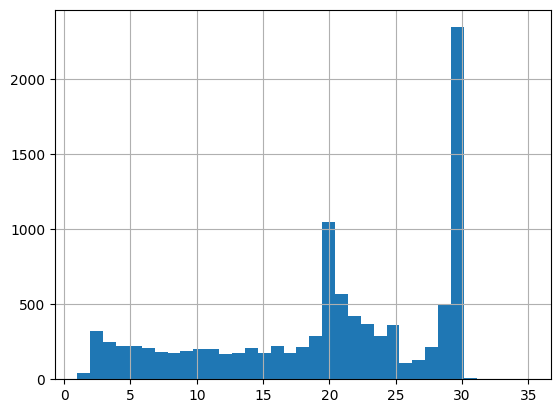

In [6]:
df_celebrities['celebrity'].value_counts().hist(bins=35)

In [7]:
df_attractiveness = df[['celebrity', 'Attractive']].groupby('celebrity').aggregate(
    count=pd.NamedAgg(column="Attractive", aggfunc="count"),
    total=pd.NamedAgg(column="Attractive", aggfunc="sum")
)

df_attractiveness['attractiveness'] = df_attractiveness.apply(lambda row: row['total'] / row['count'], axis=1)
df_attractiveness = df_attractiveness.drop(['count', 'total'], axis=1).sort_values(by='attractiveness')
df_attractiveness

,attractiveness
celebrity,
9207,0.0
2294,0.0
5396,0.0
2298,0.0
2301,0.0
...,...
8116,1.0
4227,1.0
4238,1.0


In [10]:
df_attractiveness['attractiveness'] = (df_attractiveness['attractiveness'] > 0.5) * 1
df_attractiveness

,attractiveness
celebrity,
9207,0
2294,0
5396,0
2298,0
2301,0
...,...
8116,1
4227,1
4238,1


In [33]:
df_attractive_celebrities = (
    df[['file', 'celebrity']].merge(df_attractiveness, how='left', left_on='celebrity', right_on='celebrity')
                     .drop('celebrity', axis=1)
                     .reset_index(drop=True)
                     .rename(columns={'attractiveness': 'label', 'file': 'id'})
)

df_attractive_celebrities

,id,label
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,0
3,000004.jpg,1
4,000005.jpg,1
...,...,...
202594,202595.jpg,1
202595,202596.jpg,0
202596,202597.jpg,0
202597,202598.jpg,1


In [11]:
df_attractive_photos = (
    df[['file','Attractive']].rename(columns={'Attractive': 'label', 'file': 'id'})
)

df_attractive_photos

,id,label
0,000001.jpg,1
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,1
4,000005.jpg,1
...,...,...
202594,202595.jpg,1
202595,202596.jpg,0
202596,202597.jpg,0
202597,202598.jpg,1


In [26]:
df_attractive_celebrities

,id,label
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,0
3,000004.jpg,1
4,000005.jpg,1
...,...,...
202594,202595.jpg,1
202595,202596.jpg,0
202596,202597.jpg,0
202597,202598.jpg,1


In [27]:
df_attractive_photos

,id,label
0,000001.jpg,1
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,1
4,000005.jpg,1
...,...,...
202594,202595.jpg,1
202595,202596.jpg,0
202596,202597.jpg,0
202597,202598.jpg,1


In [29]:
sum(df_attractive_celebrities['label'] == df_attractive_photos['label'])

167517

In [57]:
df_attractive_celebrities_partitions = (
    df_attractive_celebrities.merge(df_partitions, left_on='id', right_on='file')
                             .drop('file', axis=1)
)

df_celebs_train = df_attractive_celebrities_partitions[df_attractive_celebrities_partitions['partition'] == 0].sample(frac=10000/202599, random_state=1234)
df_celebs_valid = df_attractive_celebrities_partitions[df_attractive_celebrities_partitions['partition'] == 1].sample(frac=10000/202599, random_state=1234)
df_celebs_test = df_attractive_celebrities_partitions[df_attractive_celebrities_partitions['partition'] == 2].sample(frac=10000/202599, random_state=1234)

df_celebs = pd.concat([df_celebs_train, df_celebs_valid, df_celebs_test])
df_celebs.to_csv('info_celebs.csv')

In [31]:
df_attractive_photos_partitions = (
    df_attractive_photos.merge(df_partitions, left_on='id', right_on='file')
                             .drop('file', axis=1)
)

df_photos_train_pos = df_attractive_photos_partitions[(df_attractive_photos_partitions['partition'] == 0) & (df_attractive_photos_partitions['label'] == 1)].sample(int(train_images * positive_frac) + 1, random_state=1234)
df_photos_train_neg = df_attractive_photos_partitions[(df_attractive_photos_partitions['partition'] == 0) & (df_attractive_photos_partitions['label'] == 0)].sample(int(train_images * negative_frac), random_state=1234)
df_photos_valid_pos = df_attractive_photos_partitions[(df_attractive_photos_partitions['partition'] == 1) & (df_attractive_photos_partitions['label'] == 1)].sample(int(val_images * positive_frac) + 1, random_state=1234)
df_photos_valid_neg = df_attractive_photos_partitions[(df_attractive_photos_partitions['partition'] == 1) & (df_attractive_photos_partitions['label'] == 0)].sample(int(val_images * negative_frac), random_state=1234)
df_photos_test_pos = df_attractive_photos_partitions[(df_attractive_photos_partitions['partition'] == 2) & (df_attractive_photos_partitions['label'] == 1)].sample(int(test_images * positive_frac) + 1, random_state=1234)
df_photos_test_neg = df_attractive_photos_partitions[(df_attractive_photos_partitions['partition'] == 2) & (df_attractive_photos_partitions['label'] == 0)].sample(int(test_images * negative_frac), random_state=1234)

df_photos = pd.concat([df_photos_train_pos, df_photos_train_neg, df_photos_valid_pos, df_photos_valid_neg, df_photos_test_pos, df_photos_test_neg])
df_photos.to_csv('info.csv')